We will try to code Bayseian Linear Regression in this notebook

In [45]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [46]:
# Prior on thetas
def prior(mean , cov):
    return torch.distributions.MultivariateNormal(mean, cov)


mean_prior = torch.tensor([0.0 , 0.0])
cov_prior = torch.tensor([[1.0, 0.0], [0.0, 1.0]])

prior_dist = prior(mean_prior, cov_prior)

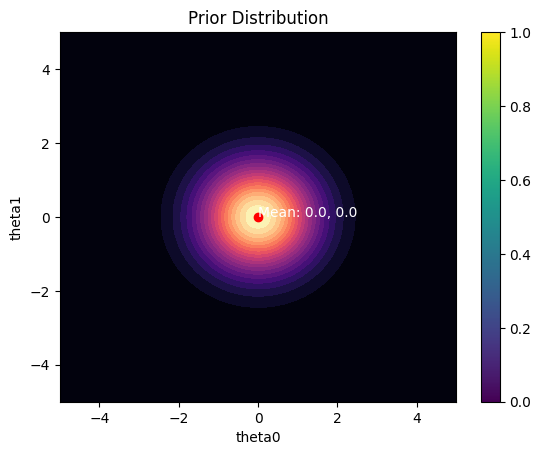

In [47]:
def plot_contour(dist):
    x = torch.linspace(-5, 5, 1000)
    y = torch.linspace(-5, 5, 1000)
    X, Y = torch.meshgrid(x, y)
    XY = torch.stack([X, Y], dim=-1)
    Z = torch.exp(dist.log_prob(XY))
    mean = dist.mean
    plt.contourf(X, Y, Z , levels = 20 , cmap = 'magma')
    plt.scatter(mean[0] , mean[1] , color = 'red')
    plt.text(mean[0] , mean[1] , "Mean: " + str(round(mean[0].item() , 2)) + ", " + str(round(mean[1].item() , 2)) , color = 'white')
    plt.xlabel("theta0")
    plt.ylabel("theta1")
    plt.colorbar()
    plt.show()

plt.title("Prior Distribution")
plot_contour(prior_dist)

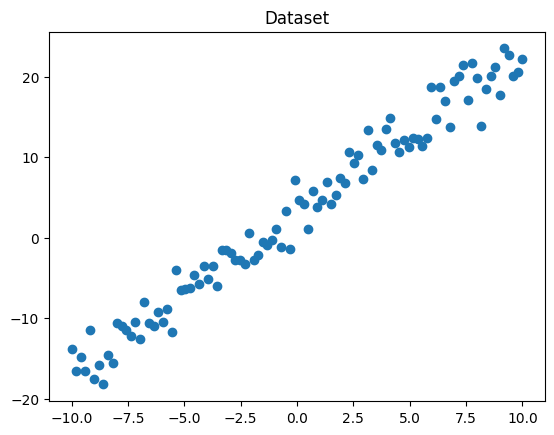

In [48]:
# Dataset generation
def generate_dataset(theta0 , theta1 , n , var):
    x = torch.linspace(-10 , 10 , n)
    y = theta1*x + theta0 + torch.distributions.Normal(0 , var).sample(x.shape)
    return x , y

n = 100
var_data = 2
X , Y = generate_dataset(3 , 2 , n , var_data)

plt.scatter(X , Y)
plt.title("Dataset")
plt.show()

In [49]:
var_likelihood = 2

In [50]:
# Make X a nx2 matrix by adding a column of ones
X = torch.stack([torch.ones(n) , X] , dim = 1) 

In [51]:
cov_posterior = torch.linalg.inv(torch.linalg.inv(cov_prior) + (1/var_likelihood)*torch.matmul(X.T , X))
mean_posterior = torch.matmul(cov_posterior , (torch.matmul(torch.linalg.inv(cov_prior),mean_prior) + (1/var_likelihood)*torch.matmul(X.T , Y)))

print("Posterior Mean: " , mean_posterior)
print("Posterior Covariance: " , cov_posterior)

Posterior Mean:  tensor([3.0121, 1.9930])
Posterior Covariance:  tensor([[1.9608e-02, 2.7478e-11],
        [2.7478e-11, 5.8777e-04]])


In [52]:
def posterior(mean , cov):
    return torch.distributions.MultivariateNormal(mean , cov)

posterior_dist = posterior(mean_posterior , cov_posterior)

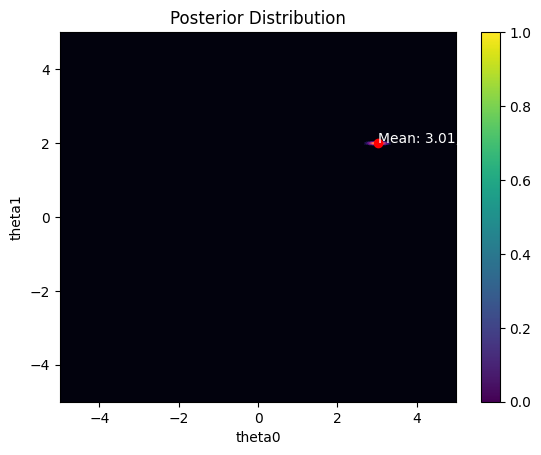

In [53]:
plt.title("Posterior Distribution")
plot_contour(posterior_dist)

In [54]:
def predictive_dist(x , mean_pos , cov_pos , var_likelihood):
    return torch.distributions.Normal(torch.matmul(x , mean_pos.T) , var_likelihood + torch.matmul(x , torch.matmul(cov_pos , x.T)))

In [55]:
prediction_dists = []
for i in range(n):
    prediction_dists.append(predictive_dist(X[i] , mean_posterior , cov_posterior , var_likelihood))

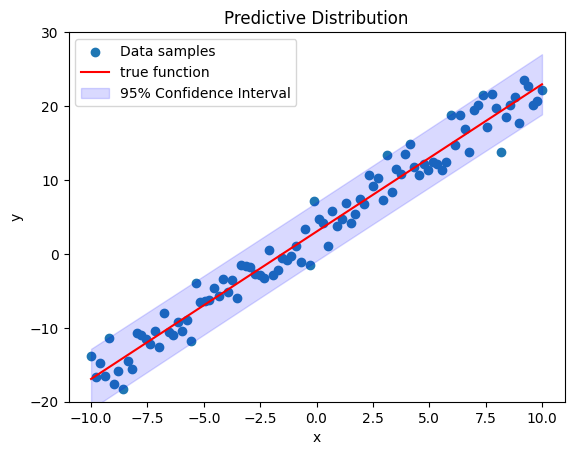

In [56]:
# Plot the prediction as a gradient with the color opacity how confident the model is
def plot_predictions(prediction_dists , X , Y):
    x_new = X[:,1]  
    plt.scatter(x_new , Y)
    y_mean = []
    y_var = []
    for i in range(n):
        dist = prediction_dists[i]
        y_mean.append(dist.mean)
        y_var.append(dist.variance)

    plt.plot(x_new , y_mean, color = 'red')
    y_upper = []
    y_lower = []
    for i in range(n):
        y_upper.append((y_mean[i] + 1.96*np.sqrt(y_var[i])))
        y_lower.append((y_mean[i] - 1.96*np.sqrt(y_var[i])))
    plt.fill_between(x_new , y_upper , y_lower , color = 'blue' , alpha = 0.15)
    plt.ylim(-20 , 30)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(["Data samples" , "true function", "95% Confidence Interval"])
    plt.title("Predictive Distribution")
    plt.show()

plot_predictions(prediction_dists , X , Y)

In [57]:
# Interactive plot of the predictions as a function of the prior mean
def plot_predictions_interactive(X , Y , mean_prior_1 , mean_prior_2 , var_likelihood):
    mean_prior = torch.tensor([mean_prior_1 , mean_prior_2])
    cov_prior = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
    prior_dist = prior(mean_prior , cov_prior)
    cov_posterior = torch.linalg.inv(torch.linalg.inv(cov_prior) + (1/var_likelihood)*torch.matmul(X.T , X))
    mean_posterior = torch.matmul(cov_posterior , (torch.linalg.inv(cov_prior)@mean_prior + (1/var_likelihood)*torch.matmul(X.T , Y)))
    posterior_dist = posterior(mean_posterior , cov_posterior)
    prediction_dists = []
    n = len(X)
    for i in range(n):
        prediction_dists.append(predictive_dist(X[i] , mean_posterior , cov_posterior , var_likelihood))
    plt.title("Posterior Distribution")
    plot_contour(posterior_dist)
    plt.title("Predictions")
    plot_predictions(prediction_dists , X , Y)

interact(plot_predictions_interactive , X = fixed(X) , Y = fixed(Y) , mean_prior_1 = (-5.0 , 5.0 , 0.1) , mean_prior_2 = (-5.0 , 5.0 , 0.1) , var_likelihood = fixed(var_likelihood))


interactive(children=(FloatSlider(value=0.0, description='mean_prior_1', max=5.0, min=-5.0), FloatSlider(value…

<function __main__.plot_predictions_interactive(X, Y, mean_prior_1, mean_prior_2, var_likelihood)>

------

Let's try to now unlearn posterior

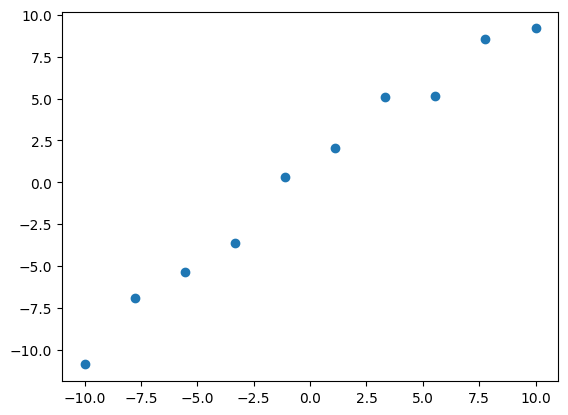

In [58]:
# Dataset generation
n = 10
var_data = 1
X , Y = generate_dataset(1 , 1 , n , var_data)


plt.scatter(X , Y)

In [59]:
# Make X a nx2 matrix by adding a column of ones
X = torch.stack([torch.ones(n) , X] , dim = 1)

In [60]:
mean_prior = torch.tensor([0.0 , 0.0])
cov_prior = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
var_likelihood = 1

prior_dist = prior(mean_prior , cov_prior)
cov_posterior = torch.linalg.inv(torch.linalg.inv(cov_prior) + (1/var_likelihood)*torch.matmul(X.T , X))
mean_posterior = torch.matmul(cov_posterior , (torch.linalg.inv(cov_prior)@mean_prior + (1/var_likelihood)*torch.matmul(X.T , Y)))
posterior_dist = posterior(mean_posterior , cov_posterior)

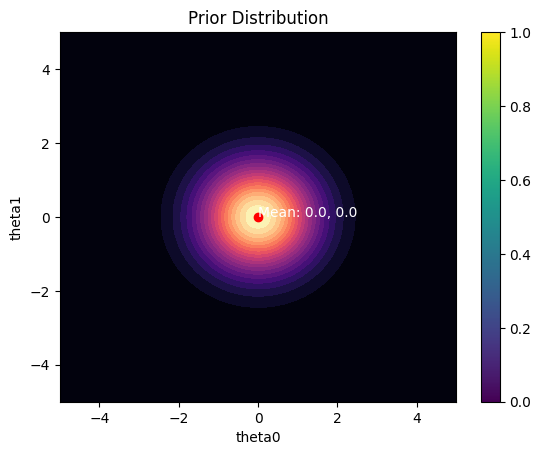

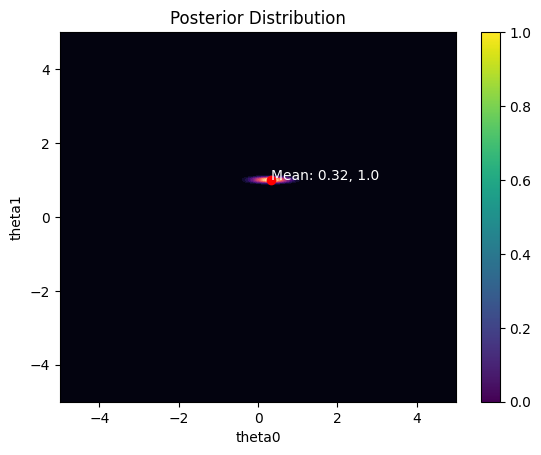

In [61]:
plt.title("Prior Distribution")
plot_contour(prior_dist)
plt.title("Posterior Distribution")
plot_contour(posterior_dist)
plt.show()

In [62]:
# Get the last point of the dataset
X_del = torch.tensor(X[-1:])
Y_del = torch.tensor(Y[-1:])

unlearned_posterior_cov = torch.linalg.inv(torch.linalg.inv(cov_posterior) - (1/var_likelihood)*torch.matmul(X_del.T , X_del))
unlearned_posterior_mean = torch.matmul(unlearned_posterior_cov , (torch.linalg.inv(cov_posterior)@mean_posterior) - (1/var_likelihood)*torch.matmul(X_del.T , Y_del))

/var/folders/nf/tcn1v_gx4pvc23db1_jd0_zr0000gq/T/ipykernel_84504/4097788031.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_del = torch.tensor(X[-1:])
/var/folders/nf/tcn1v_gx4pvc23db1_jd0_zr0000gq/T/ipykernel_84504/4097788031.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_del = torch.tensor(Y[-1:])


In [63]:
unleaned_posterior = posterior(unlearned_posterior_mean , unlearned_posterior_cov)

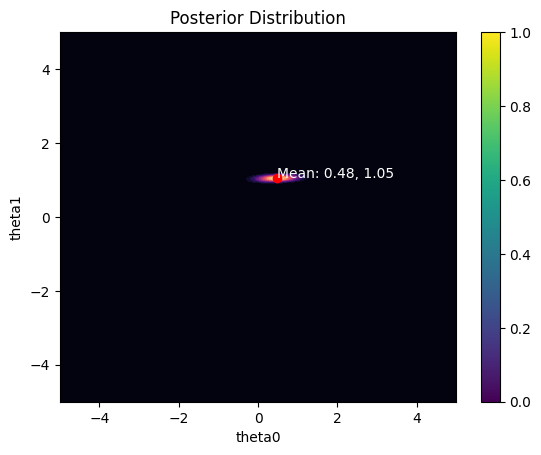

In [64]:
plt.title("Posterior Distribution")
plot_contour(unleaned_posterior)
plt.show()

In [65]:
# Interactive plot of the posterior distribution as a function of the number of points deleted
def plot_unlearned_posterior_interactive(X , Y , var_likelihood , posterior_dist , n_del):
    mean_posterior = posterior_dist.mean
    cov_posterior = posterior_dist.covariance_matrix
    # Create a dataset of last n_del points from the dataset
    X_del = torch.tensor(X[-n_del:])
    Y_del = torch.tensor(Y[-n_del:])
    # print(X_del)
    # print(Y_del)

    unlearned_posterior_cov = torch.linalg.inv(torch.linalg.inv(cov_posterior) - (1/var_likelihood)*torch.matmul(X_del.T , X_del))
    unlearned_posterior_mean = torch.matmul(unlearned_posterior_cov , (torch.linalg.inv(cov_posterior)@mean_posterior) - (1/var_likelihood)*torch.matmul(X_del.T , Y_del))


    # # Modding the unlearned mean and covariance to be positive definite
    # unlearned_posterior_cov = (unlearned_posterior_cov + unlearned_posterior_cov.T)/2
    
    unleaned_posterior = posterior(unlearned_posterior_mean , unlearned_posterior_cov)
    
    plt.title("Posterior Distribution")
    plot_contour(unleaned_posterior)
    

interact(plot_unlearned_posterior_interactive , X = fixed(X) , Y = fixed(Y) , var_likelihood = fixed(var_likelihood) , posterior_dist = fixed(posterior_dist) , n_del = (1 , n , 1))

interactive(children=(IntSlider(value=5, description='n_del', max=10, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_unlearned_posterior_interactive(X, Y, var_likelihood, posterior_dist, n_del)>